# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

Loading data

In [1]:
import torch, torchvision
from torchvision.transforms import v2

training_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    num_workers=2)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


100%|██████████| 170M/170M [00:12<00:00, 13.4MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [2]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [3]:
from torch import nn

class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )

    def forward(self, inputs):


        return self.downsample(self.norm(inputs))



class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels,
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels,
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]



        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [4]:
!pip install torchinfo # if not on Polaris

In [6]:
from torchinfo import summary

model = Classifier(32, 4, 2).to(device=dev)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [7]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()

    loss /= num_batches
    correct /= (size*batch_size)

    accuracy = 100*correct
    return accuracy, loss

In [8]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

        progress_bar.update()

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

In [10]:
from tqdm.notebook import tqdm
import pandas as pd

In [ ]:
epochs = 15
df = pd.DataFrame({
    'N': range(1, epochs + 1),
    'train_acc': [float('nan')] * epochs,  # Initialize with NaNs
    'val_acc': [float('nan')] * epochs     # Initialize with NaNs
})

In [ ]:
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training & validation loss & accuracy
    # for training data - only once every 5 epochs (takes a while)
    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            #df.loc[j,"train_acc"] = acc
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")

    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        df.loc[j,"train_acc"] = acc
        df.loc[j,"val_acc"] = acc_val
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.163, accuracy: 20.058


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.167, accuracy: 19.600


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 2.014, accuracy: 25.485


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.974, accuracy: 28.441


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.895, accuracy: 30.904


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.860, accuracy: 33.317


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.827, accuracy: 35.373


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.825, accuracy: 34.840


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.776, accuracy: 36.205


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.765, accuracy: 36.531


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.705, accuracy: 37.747


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.684, accuracy: 37.965


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.657, accuracy: 40.123


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.651, accuracy: 39.547


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.622, accuracy: 41.149


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.647, accuracy: 41.169


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.646, accuracy: 39.419


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.582, accuracy: 41.930


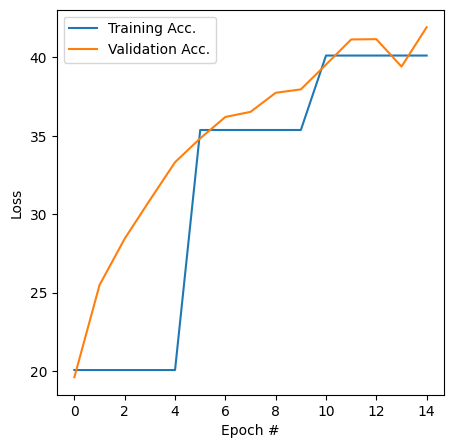

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
pltsize = 0.5
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(df[["N"]], df[["train_acc"]], label = 'Training Acc.' )
plt.plot(df[["N"]], df[["val_acc"]], label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [12]:
class ConvNextBlock(nn.Module):

    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels,
                                     groups=in_channels,
                                     kernel_size=[9,9], ############### USING A SLIGHTLY LARGER KERNEL
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels,
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            blocks_per_stage += 1 ############### ADDING A BLOCK PER STAGE
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]



        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x

In [13]:
model = Classifier(32, 4, 2).to(device=dev)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         2,624
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         2,624
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [14]:
epochs = 15
df = pd.DataFrame({
    'N': range(1, epochs + 1),
    'train_acc': [float('nan')] * epochs,  # Initialize with NaNs
    'val_acc': [float('nan')] * epochs     # Initialize with NaNs
})

for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training & validation loss & accuracy
    # for training data - only once every 5 epochs (takes a while)
    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            #df.loc[j,"train_acc"] = acc
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")

    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        df.loc[j,"train_acc"] = acc
        df.loc[j,"val_acc"] = acc_val
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.343, accuracy: 9.011


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.342, accuracy: 9.454


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 2.342, accuracy: 9.523


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 2.342, accuracy: 9.286


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 2.341, accuracy: 9.563


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 2.342, accuracy: 9.484


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 2.343, accuracy: 8.993


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 2.342, accuracy: 9.444


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 2.342, accuracy: 9.563


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 2.341, accuracy: 9.434


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 2.341, accuracy: 9.553


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 2.342, accuracy: 9.494


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 2.343, accuracy: 9.068


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 2.342, accuracy: 9.474


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 2.342, accuracy: 9.543


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 2.341, accuracy: 9.523


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 2.341, accuracy: 9.266


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 2.342, accuracy: 9.326


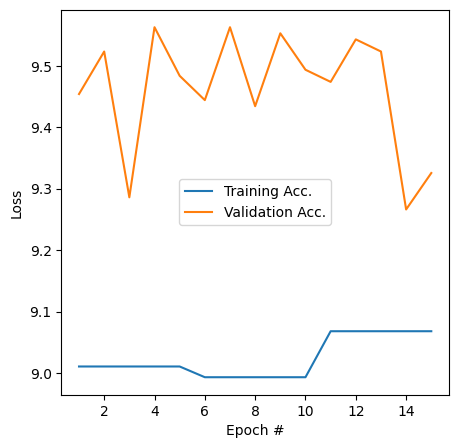

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline
pltsize = 0.5
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(df[["N"]], df[["train_acc"]], label = 'Training Acc.' )
plt.plot(df[["N"]], df[["val_acc"]], label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()